# Linear Regression with Gaussian Process

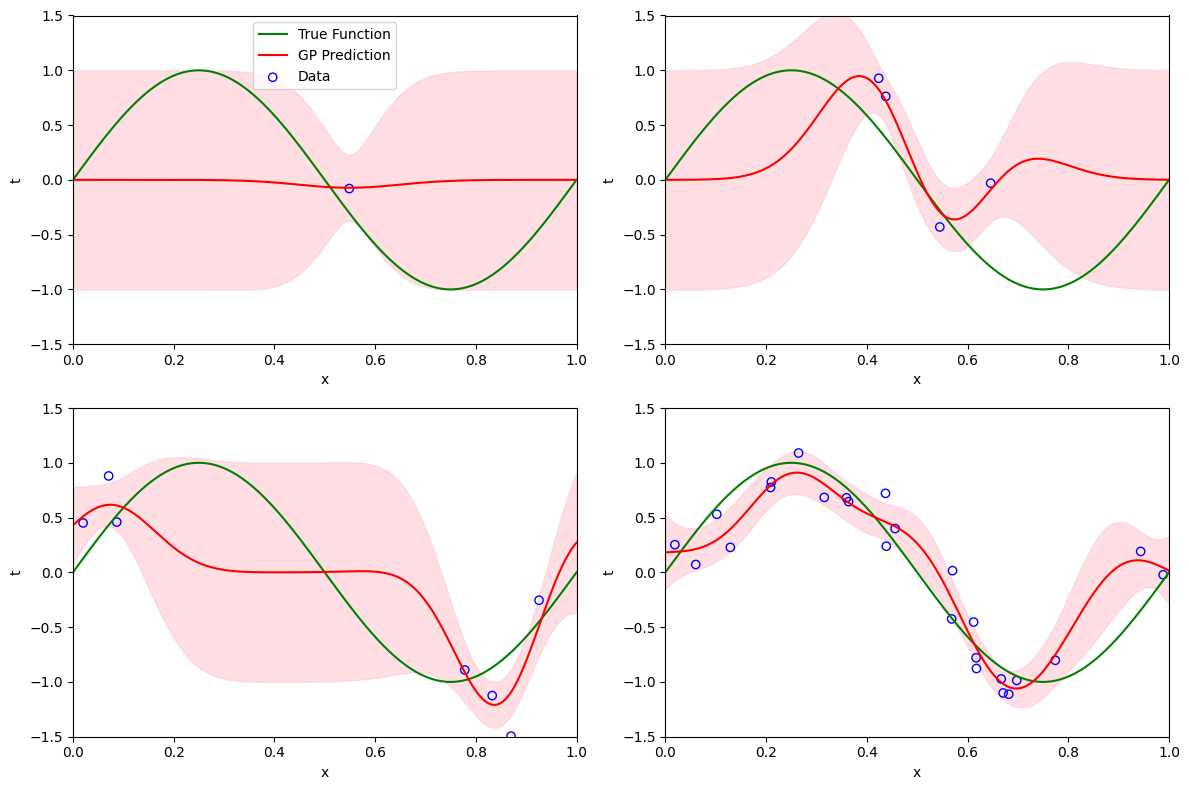

In [4]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

# Gaussian radial basis function kernel
def rbf_kernel(x1, x2, sigma=0.1):
    sqdist = np.subtract.outer(x1, x2)**2
    return np.exp(-0.5 * sqdist / sigma**2)

# generating test data: sin(2pi *)
def true_function(x):
    return np.sin(2 * np.pi * x)

# Gaussian Process regression
def gp_predict(x_train, y_train, x_test, sigma=0.1, beta_inv=0.1):
    K = rbf_kernel(x_train, x_train, sigma)
    K += beta_inv * np.eye(len(x_train))  # Noise term
    K_s = rbf_kernel(x_train, x_test, sigma)
    K_ss = rbf_kernel(x_test, x_test, sigma)

    K_inv = np.linalg.inv(K)
    mu_s = K_s.T @ K_inv @ y_train
    cov_s = K_ss - K_s.T @ K_inv @ K_s
    std_s = np.sqrt(np.diag(cov_s))

    return mu_s, std_s

# Test points
x_test = np.linspace(0, 1, 200)
y_true = true_function(x_test)

# Plot
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
data_sizes = [1, 4, 7, 25]

for idx, N in enumerate(data_sizes):
    x_train = np.sort(np.random.rand(N))
    y_train = true_function(x_train) + np.random.normal(0, 0.3, N)

    mu, std = gp_predict(x_train, y_train, x_test, sigma=0.1, beta_inv=0.1)

    ax = axs[idx // 2, idx % 2]
    ax.plot(x_test, y_true, 'g', label='True Function')
    ax.plot(x_test, mu, 'r', label='GP Prediction')
    ax.fill_between(x_test, mu - std, mu + std, color='pink', alpha=0.5)
    ax.scatter(x_train, y_train, facecolors='none', edgecolors='b', label='Data')
    ax.set_xlim(0, 1)
    ax.set_ylim(-1.5, 1.5)
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    if idx == 0:
        ax.legend()

plt.tight_layout()
plt.show()


# Stretch Goal: Grid Search on Online Shopping Data


In [7]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Fetch dataset
data = fetch_ucirepo(id=468)
X_df = data.data.features
y = data.data.targets.to_numpy().ravel()

# Encode labels if they're categorical
if y.dtype == 'object':
    y = LabelEncoder().fit_transform(y)

# Identify categorical and numeric columns
categorical_cols = X_df.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X_df.select_dtypes(include=[np.number]).columns.tolist()

# Define column transformer: scale numeric, one-hot encode categoricals
preprocessor = ColumnTransformer([
    ('num', MinMaxScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Define pipeline
pipe = Pipeline([
    ('preprocess', preprocessor),
    ('svm', SVC(kernel='rbf'))
])

# Exponential grid for C and gamma
C_range = [2**i for i in range(-5, 16, 2)]
gamma_range = [2**i for i in range(-15, 4, 2)]
param_grid = {
    'svm__C': C_range,
    'svm__gamma': gamma_range
}

# Grid search with 5-fold CV
grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1, n_jobs=-1)
grid.fit(X_df, y)

# Final results
print(f"\n Best parameters: C={grid.best_params_['svm__C']}, gamma={grid.best_params_['svm__gamma']}")
print(f" Best cross-validation accuracy: {grid.best_score_:.4f}")

# Classification report on training set
print("\nClassification Report (on full training set):")
print(classification_report(y, grid.predict(X_df)))


Fitting 5 folds for each of 110 candidates, totalling 550 fits

 Best parameters: C=32768, gamma=0.0078125
 Best cross-validation accuracy: 0.8893

Classification Report (on full training set):
              precision    recall  f1-score   support

       False       0.90      0.98      0.94     10422
        True       0.78      0.43      0.56      1908

    accuracy                           0.89     12330
   macro avg       0.84      0.70      0.75     12330
weighted avg       0.88      0.89      0.88     12330

